# Exploring multi-tasking behaviour of users

## This is not the final version multi-tasking: it doesn't consider time-out between 

In [17]:
%matplotlib inline
import pymongo
from pymongo import MongoClient
from bson.objectid import ObjectId
from datetime import datetime
import itertools
import re
import matplotlib.pylab as pylab
import numpy as np
from scipy import percentile
from scipy.stats import pearsonr, kendalltau

# DB connection to localhost
client = MongoClient()
# Get DB
db = client.db_tasklog_clean
# collection to store new data that contains task labels
# Note: only top-level task labels are used
DataLabeled = db.data_labeled
Users = db.user

users = Users.find({})

## Prepare data
* Filter out event segments that last less than 1 second (most likely it's a segment of automatic events)

In [18]:
D = []
for u in users:
    data = list(DataLabeled.find({'userid': u['userid']}))[0]['data']
    events = []
    for s in data:
        tab_group = s['tab_group']
        tabid = s['tabid']
        for ug in tab_group:
            # a group of events sharing the same url
            url_group = ug['url_group']
            # If the whole group takes less than 1 second, then it's likely that
            # that are all automatic events
            #time = (url_group[-1]['timestamp_bson'] - url_group[0]['timestamp_bson']).total_seconds()
            #if time > 1:
                #print [(e['taskid'], e['event']) for e in url_group], time
                
            # postpone this check to counting interruptions, as if we remove them now we may miss 
            # continuous events of tasks
            for e in url_group:
                events.append(e)
    D.append((u['userid'], events))


## Check the duration of sessions (is dividing sessions in terms of inactivity time between events reasonable?)
* session: x mins of tab inactivity
* x = 15, 30, 60

### Conclusion:
* Duration of sessions can vary a lot. It is perhpas not fair to say that a person does 3 tasks in a 2-hour long session is more multi-tasking than a person does 1 task in a 15 mins session. 
* Depending on the threshold, the duration of sessions can vary, but in general the relative level of multi-tasking of users are similar.  
* High correlation between number of tasks a uesr performs and his/her multi-tasking level: questionable validity of the measure.

Threshold for session: 15 min
['1.6', '6.2', '0.5', '2.4', '2.7', '3.5', '1.9', '3.5', '5.1', '1.4', '2.9', '7.7', '1.5', '0.7', '0.8', '2.3', '2.5', '3.5', '4.4', '3.5', '1.4', '3.4', '2.6']
r=0.61 p-value=0.00 tau=0.40 p-value=0.01

Threshold for session: 30 min
['2.1', '7.6', '0.6', '2.5', '3.7', '4.1', '2.5', '4.0', '6.6', '1.9', '4.0', '8.8', '1.5', '0.9', '1.0', '3.0', '2.9', '3.7', '4.8', '4.5', '1.7', '4.6', '3.2']
r=0.61 p-value=0.00 tau=0.39 p-value=0.01

Threshold for session: 60 min
['2.4', '7.8', '0.8', '3.0', '5.7', '4.4', '2.9', '3.9', '8.0', '2.4', '5.6', '9.7', '1.8', '1.2', '1.2', '4.1', '3.5', '4.2', '5.2', '4.6', '1.9', '4.9', '4.3']
r=0.65 p-value=0.00 tau=0.42 p-value=0.01



([array([ 767.,   34.,   14.,    5.,    1.,    0.,    0.,    0.,    0.,    0.]),
  array([ 454.,   51.,   18.,    7.,    2.,    1.,    1.,    0.,    0.,    1.]),
  array([ 238.,   59.,   30.,   17.,    6.,    3.,    1.,    0.,    0.,    2.])],
 array([   0.        ,   98.03804167,  196.07608333,  294.114125  ,
         392.15216667,  490.19020833,  588.22825   ,  686.26629167,
         784.30433333,  882.342375  ,  980.38041667]),
 <a list of 3 Lists of Patches objects>)

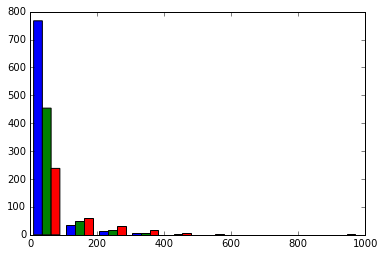

In [19]:
X = []
for thresh in [15, 30, 60]:
    duration = []
    M = []
    # For getting the number of tasks user has performed
    T = []
    for uid, data in D:
        # devide event sequence into sessions
        sessions = []
        session = [data[0]]
        tasks = list(set([e['taskid'] for e in data]))
        T.append(len(tasks))
        i = 0
        for e in data:
            if i > 0:
                time = (e['timestamp_bson'] - data[i-1]['timestamp_bson']).total_seconds()/60
                # If inactivity > threshold, start a new session
                if time > thresh:
                    session_length = (session[-1]['timestamp_bson'] - session[0]['timestamp_bson']).total_seconds()/60
                    duration.append(session_length)
                    #if session_length == 0:
                    #    print [s['event'] for s in session]
                    sessions.append(session)
                    session = []
                session.append(e)
            i += 1
            # Get number of tasks per session
        counts = ([len(set([e['taskid'] for e in session]) - set(['None'])) for session in sessions])
        M.append(np.mean(counts))
    print 'Threshold for session: %s min'%thresh
    print ['%.1f'%m for m in M]    
    # Check duration of sessions
    X.append(duration)
    # Check if there is a correlation bewteen M and T
    corr, p = pearsonr(M, T)
    tau, p2 = kendalltau(M, T)
    print 'r=%.2f'%corr, 'p-value=%.2f'%p, 'tau=%.2f'%tau, 'p-value=%.2f'%p2
    print

pylab.hist(X, 10)
#    pylab.title('Inactivity threshold: %s mins'%thresh)

#for i in range(len(X)):
#    print percentile(X[i], 25), percentile(X[i], 75)


## How to measure multi-tasking? How about from the perspective of completing a single task?

* A task is interupted by other tasks, i.e., the user would come back to a task after switching to another task
* The frequency of this interupt within a certain period (e.g., during a day, 2 hours, etc)

### Observation:
* large difference between average number of interruptions (user difference)
* large standard deviation (difference between tasks)

In [20]:
# Group events by fixed time period: 30 mins, 60 mins, 120 mins
def count_interrupt(period, gap_thresh, data):
    # Get all tasks a user has done excluding None
    tasks = list(set([e['taskid'] for e in data]))
    # Get the duration of each task: so that we know if a task is interrupted (come back to the task) 
    # or finished (does not come back to the task)
    ending_time = {}
    for t in tasks:
        events = itertools.ifilter(lambda x: x['taskid'] == t, data)
        ending_time[t] = max([e['timestamp_bson'] for e in events])
        
    interrupt = dict([(t, 0) for t in tasks])

    task_sessions = dict([(t, []) for t in tasks])
    current_task = data[0]['taskid']
    session = [data[0]]
    for e in data[1:]:
        if not e['taskid'] == current_task:
            # If the next task is None, ignore the interruption
            if not (e['taskid'] in ['None'] or session == []):
                tmp = task_sessions.get(current_task, [])
                tmp.append(session)   
                task_sessions[current_task] = tmp
            current_task = e['taskid']
            session = []
        # If the current event belongs to None task, don't add it    
        if not current_task == 'None':
            session.append(e)  
    if not (e['taskid'] in ['None'] or session == []):
        tmp = task_sessions.get(current_task, [])
        tmp.append(session)
        task_sessions[current_task] = tmp
        
    # count interruptions
    for t in task_sessions:
        # condition 1: task will come back
        # condition 2: the interruption happens before the fixed period ends
        # condition 3: the interruption last longer than 10 seconds
        sessions = task_sessions[t]
        for i in range(len(sessions)):
            s = sessions[i]
            #print s
            time = (s[-1]['timestamp_bson'] - s[0]['timestamp_bson']).total_seconds() < period*60
            if i < len(sessions)-1 and time:
                gap = (sessions[i+1][0]['timestamp_bson'] - s[-1]['timestamp_bson']).total_seconds()
                if gap > gap_thresh:
                    interrupt[t] += 1
        
    return interrupt
    
    
for period in [30, 60, 120]:
    for gap_thresh in [1, 5, 10, 20, 30]:
        print 'Within a %s mins period:'%period, 'interruption gap: %s sec'%gap_thresh
        M = []
        S = []
        for uid, data in D:
            interrupt = count_interrupt(period, gap_thresh, data)
            # Note: we do count if a general task interrupts a user defined task as an interruption, 
            # but we are not interested in how general task is interrupted by other tasks
            c = [interrupt[i] for i in interrupt if not i in ['None', '001', '002', '003', '004', '000']]
            M.append(np.mean(c))
            S.append(np.std(c))
        print ['%.1f'%m for m in M]
        print ['%.1f'%s for s in S]


Within a 30 mins period: interruption gap: 1 sec
['1.7', '13.2', '2.8', '15.3', '24.1', '11.4', '7.4', '24.1', '15.7', '8.2', '20.8', '97.4', '1.9', '2.0', '1.0', '3.3', '3.0', '7.2', '13.3', '27.5', '1.6', '31.2', '5.2']
['2.1', '23.1', '3.3', '17.0', '34.4', '12.1', '8.9', '24.7', '23.9', '9.7', '28.6', '130.7', '1.8', '2.8', '1.0', '5.0', '4.2', '9.8', '19.3', '21.2', '1.9', '28.1', '7.2']
Within a 30 mins period: interruption gap: 5 sec
['1.2', '11.1', '2.8', '13.2', '23.8', '11.0', '6.4', '20.5', '15.1', '7.7', '18.5', '82.2', '1.8', '2.0', '1.0', '3.2', '2.4', '6.5', '11.9', '24.6', '1.5', '29.6', '5.0']
['1.9', '18.7', '3.3', '14.9', '33.8', '11.6', '7.3', '21.7', '22.9', '9.5', '25.6', '110.1', '1.6', '2.8', '1.0', '5.0', '3.5', '8.3', '16.6', '19.2', '1.7', '27.0', '7.1']
Within a 30 mins period: interruption gap: 10 sec
['1.2', '10.3', '2.8', '12.3', '22.7', '10.0', '5.6', '19.6', '14.2', '7.2', '17.2', '73.5', '1.4', '1.8', '1.0', '3.1', '2.4', '6.0', '11.2', '21.8', '1.5', 

## Correlation between number of tasks and level of multi-tasking (average number of interruptions)
* Note: since the variances are high, average number of interruptions may not be a good indication

### Conclusion: No significant correlation was found.

Within a 30 mins period:
r=0.17 p-value=0.43 tau=0.20 p-value=0.18

Within a 60 mins period:
r=0.17 p-value=0.43 tau=0.20 p-value=0.18

Within a 120 mins period:
r=0.17 p-value=0.43 tau=0.20 p-value=0.18



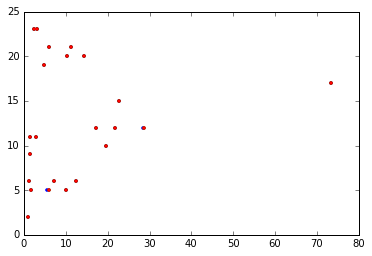

In [21]:
# set gap_thresh to 10 seconds
gap_thresh = 10

for period in [30, 60, 120]:
    print 'Within a %s mins period:'%period 
    
    # For averate number of interruptions
    M = []
    # For number of tasks a user performed (only look at top level tasks)
    T = []
    for uid, data in D:
        interrupt = count_interrupt(period, gap_thresh, data)
        c = [interrupt[i] for i in interrupt if not i in ['000', '001', '002', '003', '004', 'None']] 
        M.append(np.mean(c))
        tasks = list(set([e['taskid'] for e in data if not e['taskid'] in ['None', '000', '001', '002', 
                                                                           '003', '004']]))
        T.append(len(tasks))
    corr, p = pearsonr(M, T)
    tau, p2 = kendalltau(M, T)
    print 'r=%.2f'%corr, 'p-value=%.2f'%p, 'tau=%.2f'%tau, 'p-value=%.2f'%p2
    print    
    pylab.plot(M, T, '.')

## Correlation between the number of interruptions a task has, and its properties
* Only analyse tasks that have postQ answers
* Note: 5 tasks were annotated but did not find annotation in the log. It could be that the users did not annotate that task, or did not actually perform that task, or that the annotation was inconsistent and moved to a more general category.

In [22]:
bloom_map = {
    'remember': 1,
    'understadn': 2,
    'apply': 3,
    'analyse': 4,
    'evaluate': 5,
    'create': 6
}

# Get postQ annotated tasks
task_prop = {}
for uid, data in D:
    # Get task properties
    postQ = Users.find({'userid': uid})[0]['postQ']['questionnaire']
    for task in postQ:
        for key in postQ[task]:
            if key == 'task_goals_quantity':
                continue
            answer = postQ[task][key]
            if key == 'task_complexity_objective':
                answer = bloom_map[answer]
            tmp = task_prop.get(key, [])
            tmp.append((task, answer))
            task_prop[key] = tmp          

for period in [30, 60, 120, 240]:
    print 'Within a %s mins period:'%period 
    
    task_interruption = []
    for uid, data in D:
        #tasks = set([t['taskid'] for t in data])
        #print [(t, t in tasks_postQ) for t in tasks]
        # Get interruption counts
        interrupt = count_interrupt(period, gap_thresh, data)
        for c in interrupt:
            # Don't need this, annotated tasks do not include these.
            #if not c in ['None', '000', '001', '002', '003', '004']:
            task_interruption.append((c, interrupt[c]))
            #print c, interrupt[c]
    task_interruption = dict(task_interruption)
    
    # Correlation analysis
    for key in task_prop:
        tp = dict(task_prop[key])
        tasks_postQ = tp.keys()
        tasks_inter = task_interruption.keys()
        common_tasks = list(set(tasks_postQ).intersection(set(tasks_inter)))
        # Get data
        X = [tp[t] for t in common_tasks]
        Y = [task_interruption[t] for t in common_tasks]
        # Correlation
        tau, p = kendalltau(X, Y)
        if p < 0.05:
            key = '\\textbf{' + key + '}'
        print key, 'tau=%.2f'%tau, 'p-value=%.2f'%p
        
    print
    

Within a 30 mins period:
\textbf{task_stage} tau=-0.17 p-value=0.00
\textbf{task_collaboration} tau=0.15 p-value=0.01
task_difficulty_subjective tau=0.09 p-value=0.12
task_sailence_subjective tau=0.01 p-value=0.83
\textbf{task_urgency_subjective} tau=0.12 p-value=0.04
task_frequency tau=0.06 p-value=0.32
task_satisfaction tau=-0.11 p-value=0.06
task_knowledge_topic tau=-0.11 p-value=0.05
\textbf{task_complexity_objective} tau=0.17 p-value=0.00
task_knowledge_procedure tau=-0.05 p-value=0.41
\textbf{task_length} tau=0.24 p-value=0.00
\textbf{task_complexity_subjective} tau=0.12 p-value=0.04

Within a 60 mins period:
\textbf{task_stage} tau=-0.17 p-value=0.00
\textbf{task_collaboration} tau=0.15 p-value=0.01
task_difficulty_subjective tau=0.09 p-value=0.14
task_sailence_subjective tau=0.01 p-value=0.86
\textbf{task_urgency_subjective} tau=0.12 p-value=0.04
task_frequency tau=0.06 p-value=0.30
task_satisfaction tau=-0.11 p-value=0.06
task_knowledge_topic tau=-0.11 p-value=0.06
\textbf{tas